<a href="https://colab.research.google.com/github/wjshamblin/Monk_Object_Detection/blob/master/Roboflow_EfficientDet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For the most up to date version of this notebook, please copy from this link


---



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZmbeTro4SqT7h_TfW63MLdqbrCUk_1br#scrollTo=KwDS9qqBbMQa)




# Overview

💡 Recommendation: Open this blog post on [how to train EfficientDet](https://towardsdatascience.com/training-efficientdet-object-detection-model-with-a-custom-dataset-25fb0f190555) to continue.

In this notebook we show an example of how to train EfficientDet using a pytorch implementation on a custom dataset that has been uploaded through RoboFlow. The example provides a flexible framework, so you can apply it to your own dataset with a custom number of classes and a different objective. We we tackle chess here. 

![Chess Example](https://i.imgur.com/nkjobw1.png)

### **Our Data and Roboflow**

Our dataset of 289 chess images (and 2894 annotations!) is hosted publicly on Roboflow [here](https://public.roboflow.ai/object-detection/chess-full). Roboflow also hosts many other public datasets and you can easily upload your own custom dataset for your use case, augment, and export in flexible formats. Our tutorial uses Coco Json, but you might have another format (say tfrecord). No problem! Upload your dataset and we will export it in the required format.

### **Model and Training**

For a deep dive on the EfficientDet model please see [the paper](https://arxiv.org/abs/1911.09070). For a shorter look, here is a great [blog post](https://towardsdatascience.com/efficientdet-scalable-and-efficient-object-detection-review-4472ffc34fd9)! 

We use a pytorch implementation of EfficientDet using the [image detection library](https://github.com/roboflow-ai/Monk_Object_Detection) from Tessellate-Imaging for object detection. Our implementation uses the base version of EfficientDet-d0.  We train from the EfficientNet base backbone, without using a pretrained checkpoint for the detector.

### **Inference**

We witness some fast inference on a few basic examples from our test set to see that our approach is heading in the right direction.

### **Export**

We export our model weights to google drive for future utilization.

### **Next Steps**

We will be exploring evaluation on custom RoboFlow datasets and objectives compared to yoloV3, including training time, inference time, model size, and performance. 

We will also explore comparing performance from the Coco pretrained checkpoint!

## **Stay in touch!**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out to us](roboflow.ai)! 

#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)



# Setting up our envionment

In [1]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

fatal: destination path 'Monk_Object_Detection' already exists and is not an empty directory.


In [1]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

In [2]:
#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=53241244de5d542ba1161f2be41f81c4d89419baa79ce388cdc03a93c62139b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-xv9igesq/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


# Let's get some data! 

The best part about Roboflow is the efficient management of your datasets. [Upload you dataset](roboflow.ai) and you will recieve a fresh curl code to ouput it in whatever augmented and annotated format you need. 

In [3]:
#fresh curl courtesy of roboflow.ai, outputing our dataset in Coco Json format

##THIS CELL NEEDS CHANGED##

!curl -L https://public.roboflow.ai/ds/frnjH3vWjO?key=b8exJpgaE0 > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1089      0 --:--:-- --:--:-- --:--:--  1088
100 8031k  100 8031k    0     0  4642k      0  0:00:01  0:00:01 --:--:-- 24.5M
Archive:  roboflow.zip
 extracting: train/f3a5df526393445c6e2d38f66c1f5c27_jpg.rf.09aeba93cdea53cc6a6db62f6056ec35.jpg  
 extracting: train/614811e933a680fd6535ac8bf06bf530_jpg.rf.0b9ea19fb73269b21cf021c584b84aeb.jpg  
 extracting: train/dd6b5c3cb2d7e77f38f1dfeb2bff0431_jpg.rf.065f8833508d101a1f1449e8fbabc314.jpg  
 extracting: test/e0d38d159ad3a801d0304d7e275812cc_jpg.rf.0cd06a940ccc9894109d83792535e3eb.jpg  
 extracting: train/5cecd3b3946aac5c713a51e0bd4617c9_jpg.rf.03286d3792ba33d52a3654e14735c974.jpg  
 extracting: train/e79deba8fe520409790b601ad61da4ee_jpg.rf.016bc04dee292f80d1f975931f32bc21.jpg  
 extracting: train/0f4512d71c096f2699d705792e88fc58_jpg.rf.0971fe35ffe3ebb

In [4]:
#let's take a look at our directory
#notice the data came down in train, valid, test, splits - this is pre set during the dataset upload process
%ls

drive/                  README.dataset.txt   sample_data/  train/
Monk_Object_Detection/  README.roboflow.txt  test/         valid/


In [5]:
#let's take a peak in train
#jpg images and some coco json annotations
%ls train

00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.59f0f02a28f020d480fd5d1d8aa32f6d.jpg
0115e4df73475b550e5c6f7a88b2474f_jpg.rf.dfa577bd4af5440d689046c2f48bc48e.jpg
02f0931b536dfba10affc3231a3d64fb_jpg.rf.7daf233a70122377355a36ca33e82aa4.jpg
0301b7f9ed4d5ba503fda79fc4370c29_jpg.rf.3ecfd27607406c9f46c1525efd39e17b.jpg
03886821377011fec599e8fa12d86e89_jpg.rf.78d439f975872bc0120d597bd265684b.jpg
03d3ff4582c8125d69c19a72f846bec8_jpg.rf.5f77781cbc56eff8679f258ff4f7cc9f.jpg
040f2bcba5afce3afafdd5bbf36d2ca5_jpg.rf.fe6d0720247b60f2c6e1cda98fd00cab.jpg
04aed88a8d23cf27e47806eb23948495_jpg.rf.4021af803b1b21022221cd3654117580.jpg
055b79dd8db4c43e1a23be6095aaf624_jpg.rf.3eddea89d44864ecd7971d2827ee88df.jpg
05de676d5078dc0a13796f3f627993ef_jpg.rf.70a6ddff100e5f321d7d6f8d4d977e3d.jpg
06770ce99d4866165c0dfb104179c361_jpg.rf.e7acda724f1beddf07e9cc9ee750f3d5.jpg
0798bfb058da59d189c1bfadcf814f29_jpg.rf.b73199953251d84e4895a862463b7964.jpg
0b4ba28f0c759a11750a6430649b52e3_jpg.rf.c732477a7f65117e3fb24bbd7bca5b8e.jpg

In [0]:
#let's take a peek at the annotations
#class categories, and bounding boxes are provided for our train set
%pycat train/_annotations.coco.json

In [0]:
#in the next three cells, we move the data into a structure that the image detection library will be expecting
#but no file data manipulation is necessary
#images can also be segmented into class folders, but we combine all classes here
!mkdir Chess
!mkdir Chess/annotations
!mkdir Chess/Annotations
!mkdir Chess/Images

In [0]:
%cp train/_annotations.coco.json Chess/annotations/instances_Images.json

In [0]:
%cp train/*.jpg Chess/Images/

# Training

In this section we set up the efficientDet-d0 model from backbone and train to our custom case

In [0]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [0]:
from train_detector import Detector

In [0]:
gtf = Detector();

In [0]:
#directs the model towards file structure
root_dir = "./";
coco_dir = "Chess";
img_dir = "./";
set_dir = "Images";

In [14]:
#smells like some free compute from Colab, nice
gtf.Train_Dataset(root_dir, coco_dir, img_dir, set_dir, batch_size=8, image_size=512, use_gpu=True)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [15]:
gtf.Model();

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [0]:
gtf.Set_Hyperparams(lr=0.0001, val_interval=1, es_min_delta=0.0, es_patience=0)

In [17]:
%%time
gtf.Train(num_epochs=100, model_output_dir="trained/");

Monk_Object_Detection/4_efficientdet/lib/src/model.py:251: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(inputs) == 2:
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:84: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  image_shape = np.array(image_shape)
Monk_Object_Detection/4_efficientdet/lib/src/utils.py:96: TracerWarning: torch.from_numpy results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this fu


Epoch    54: reducing learning rate of group 0 to 1.0000e-05.



Epoch    66: reducing learning rate of group 0 to 1.0000e-06.



Epoch    72: reducing learning rate of group 0 to 1.0000e-07.



Epoch    76: reducing learning rate of group 0 to 1.0000e-08.



CPU times: user 15min 11s, sys: 2min, total: 17min 11s
Wall time: 19min 3s


# Inference

In [0]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [0]:
from infer_detector import Infer

In [0]:
gtf = Infer();

In [0]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="trained/")

In [0]:
#extract class list from our annotations
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [23]:
class_list

['pieces',
 'black-bishop',
 'black-king',
 'black-knight',
 'black-pawn',
 'black-queen',
 'black-rook',
 'white-bishop',
 'white-king',
 'white-knight',
 'white-pawn',
 'white-queen',
 'white-rook']

In [24]:
%%time
#bang!
img_path = "test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

Done. (0.065s)
CPU times: user 99 ms, sys: 7.97 ms, total: 107 ms
Wall time: 143 ms


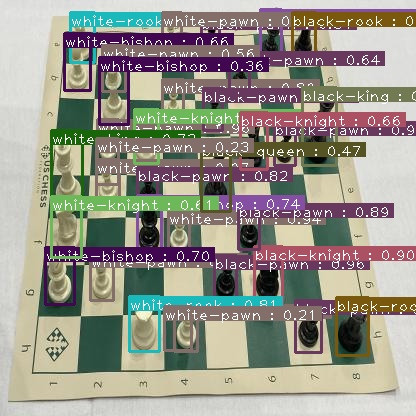

In [25]:
from IPython.display import Image
Image(filename='output.jpg') 

# Export Trained Weights

In [26]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%mkdir trained_export
%cp ./trained/signatrix_efficientdet_coco.onnx ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).onnx
%cp ./trained/signatrix_efficientdet_coco.pth ./trained_export/signatrix_efficientdet_coco_$(date +%F-%H:%M).pth
%mv ./trained_export/* /content/drive/My\ Drive/

# Reloading Trained Weights after Export

Imagine you have exported your trained model and would like to reaccess it later. This portion of the notebook picks up the trained model and starts at inference


In [28]:
#export trained model
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#our fork of the Tessellate-Imaging image detection library
#!rm -rf Monk_Object_Detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

fatal: destination path 'Monk_Object_Detection' already exists and is not an empty directory.


In [30]:
# For colab use the command below
# Set up library requirments
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

#fixed version of tqdm output for Colab
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
#IGNORE restart runtime warning, it is indeed installed
#missing a few extra packages that we will need later! 
!pip install efficientnet_pytorch
!pip install tensorboardX

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47867 sha256=66cb13e7782e143a7e9ffe5aacf393d455a8a4fe61235b9fa329d07647173686
  Stored in directory: /tmp/pip-ephem-wheel-cache-7neru0ct/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [31]:
#recover trained weights
!mkdir '/trained'
#note these are old weights that I didn't train for too long
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx' '/trained/signatrix_efficientdet_coco.onnx'
!cp '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth' '/trained/signatrix_efficientdet_coco.pth'

cp: cannot stat '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.onnx': No such file or directory
cp: cannot stat '/content/drive/My Drive/signatrix_efficientdet_coco_2020-04-10-15:18.pth': No such file or directory


In [0]:
import os
import sys
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [0]:
from infer_detector import Infer
gtf = Infer();

In [34]:
#our trained model weights are in here in onxx format
gtf.Model(model_dir="/trained")

FileNotFoundError: ignored

In [0]:
#download some test data
!curl -L [YOUR LINK HERE] | jar -x

In [0]:
!ls test

In [0]:
#extract class list from our annotations
#in your application you will probably already have this saved
import json
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [0]:
class_list

In [0]:
%%time
#bang!
img_path = "test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.49b342a7b1f6de3f0e328beaf094a945.jpg";
duration, scores, labels, boxes = gtf.Predict(img_path, class_list, vis_threshold=0.2);

In [0]:
from IPython.display import Image
Image(filename='output.jpg') 